In [10]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import CanonSmiles, Draw, MolFromSmiles
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity

import mols2grid

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

First we download the model from the given url and store in the `models/` directory

In [5]:
encoder1, tokenizer1 = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/barlow_closed.pkl"
)

Loading model from s3://terray-public/models/barlow_closed.pkl
Loading tokenizer may_closedparen from s3://terray-public/models/barlow_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
20561664 params frozen!


In [6]:
encoder2, tokenizer2 = load_coati2(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/coati2_chiral_03-08-24.pkl"
)

Loading model from s3://terray-public/models/coati2_chiral_03-08-24.pkl


Loading tokenizer coati2_12_12 from s3://terray-public/models/coati2_chiral_03-08-24.pkl
number of parameters: 50.44M
number of parameters Total: xformer: 54.81M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
56385536 params frozen!


In [15]:
def gen_mol(smiles, coati_version=1, num_variations=100, noise_scale=0.15):

    # Embed the SMILES string
    smiles = CanonSmiles(smiles)

    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

    # Retrieve canonical SMILES of generated analogs
    unique_valid_smiles = list(set([CanonSmiles(smi) for smi in nearby_smiles if MolFromSmiles(smi)]))

    # Store true if original molecule is in the set of generated analogs
    had_orig = smiles in unique_valid_smiles

    unique_valid_smiles = list(set([smiles] + unique_valid_smiles))

    # Generate molecular fingerprints
    fp = RDKFingerprint(MolFromSmiles(smiles), minPath=1, maxPath=7, fpSize=2048)
    fps = [RDKFingerprint(MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048) for x in unique_valid_smiles]

    # Compute tanimoto similarities between distributions and store as list of strings
    sim = BulkTanimotoSimilarity(fp, fps)
    sim_str = [str(round(x, 2)) for x in sim]

    unique_valid_smiles, sim_str = zip(*sorted(zip(unique_valid_smiles, sim_str), key=lambda x:x[1], reverse=True))

    if not had_orig:
        unique_valid_smiles, sim_str = zip(*[[i, f"{j} (Added)"] if i==smiles else [i, j] for i, j in zip(unique_valid_smiles, sim_str)])

    # Output for molecule generation
    print (f"Attempted {num_variations} COATI{coati_version} generations with a noise scale of {noise_scale} and generated {len(unique_valid_smiles)} unique structures.")
    
    # Display molecules and tanimoto similarity to initial fragment
    display(Draw.MolsToGridImage([MolFromSmiles(s) for s in unique_valid_smiles], molsPerRow=5, subImgSize=(200, 200), maxMols=100, legends=sim_str))
    
    return unique_valid_smiles

### Input a SMILES string

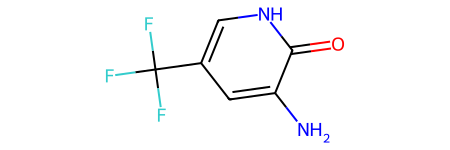

In [11]:
smiles_str = "Nc1cc(c[nH]c1=O)C(F)(F)F"
mol = MolFromSmiles(smiles_str)
mol

Attempted 100 COATI1 generations with a noise scale of 0.05 and generated 3 unique structures.


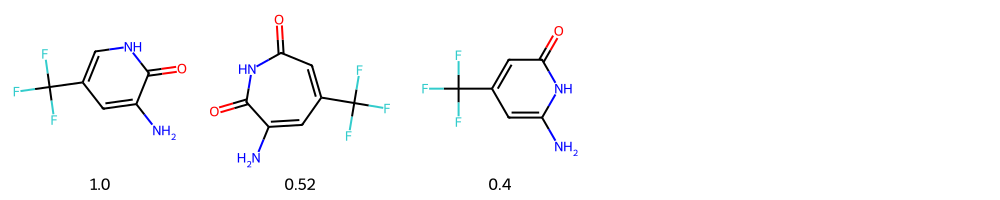

In [12]:
unique_valid_smiles_0p05_1 = gen_mol(smiles_str, coati_version = 1, num_variations = 100, noise_scale = 0.05)

Attempted 100 COATI2 generations with a noise scale of 0.05 and generated 1 unique structures.


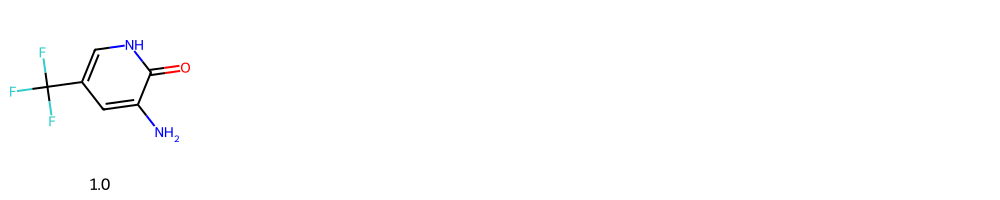

In [13]:
unique_valid_smiles_0p05_2 = gen_mol(smiles_str, coati_version = 2, num_variations = 100, noise_scale = 0.05)

Attempted 100 COATI1 generations with a noise scale of 0.15 and generated 4 unique structures.


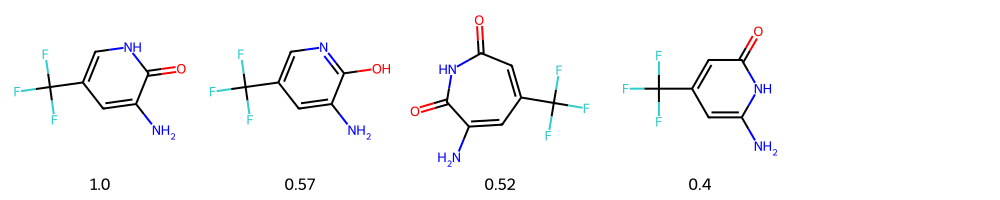

In [14]:
unique_valid_smiles_0p15_1 = gen_mol(smiles_str, coati_version = 1, num_variations = 100, noise_scale = 0.15)

Attempted 100 COATI2 generations with a noise scale of 0.15 and generated 1 unique structures.


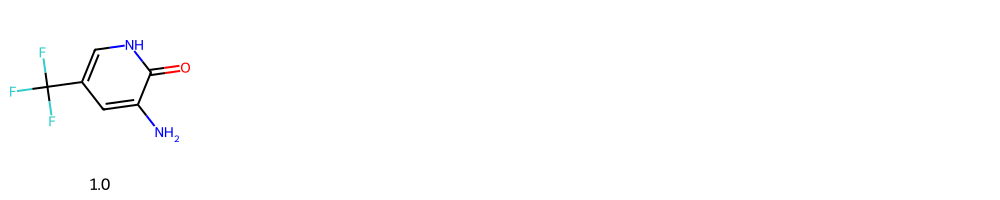

In [16]:
unique_valid_smiles_0p15_2 = gen_mol(smiles_str, coati_version = 2, num_variations = 100, noise_scale = 0.15)

Attempted 100 COATI1 generations with a noise scale of 0.25 and generated 4 unique structures.


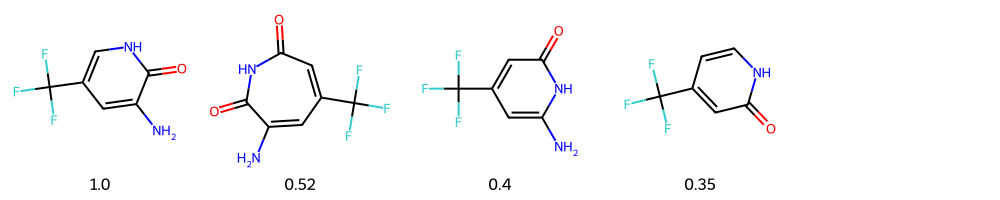

In [17]:
unique_valid_smiles_0p25_1 = gen_mol(smiles_str, coati_version = 1, num_variations = 100, noise_scale = 0.25)

Attempted 100 COATI2 generations with a noise scale of 0.25 and generated 5 unique structures.


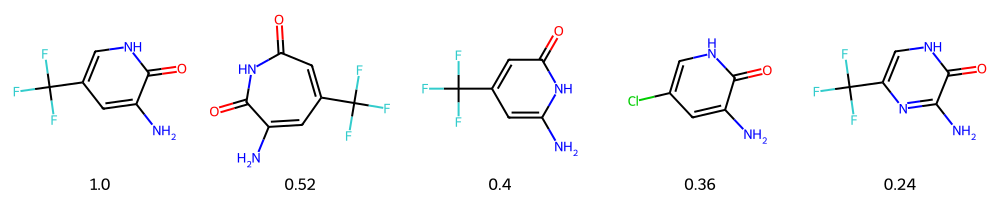

In [18]:
unique_valid_smiles_0p25_2 = gen_mol(smiles_str, coati_version = 2, num_variations = 100, noise_scale = 0.25)

Attempted 100 COATI1 generations with a noise scale of 0.5 and generated 49 unique structures.


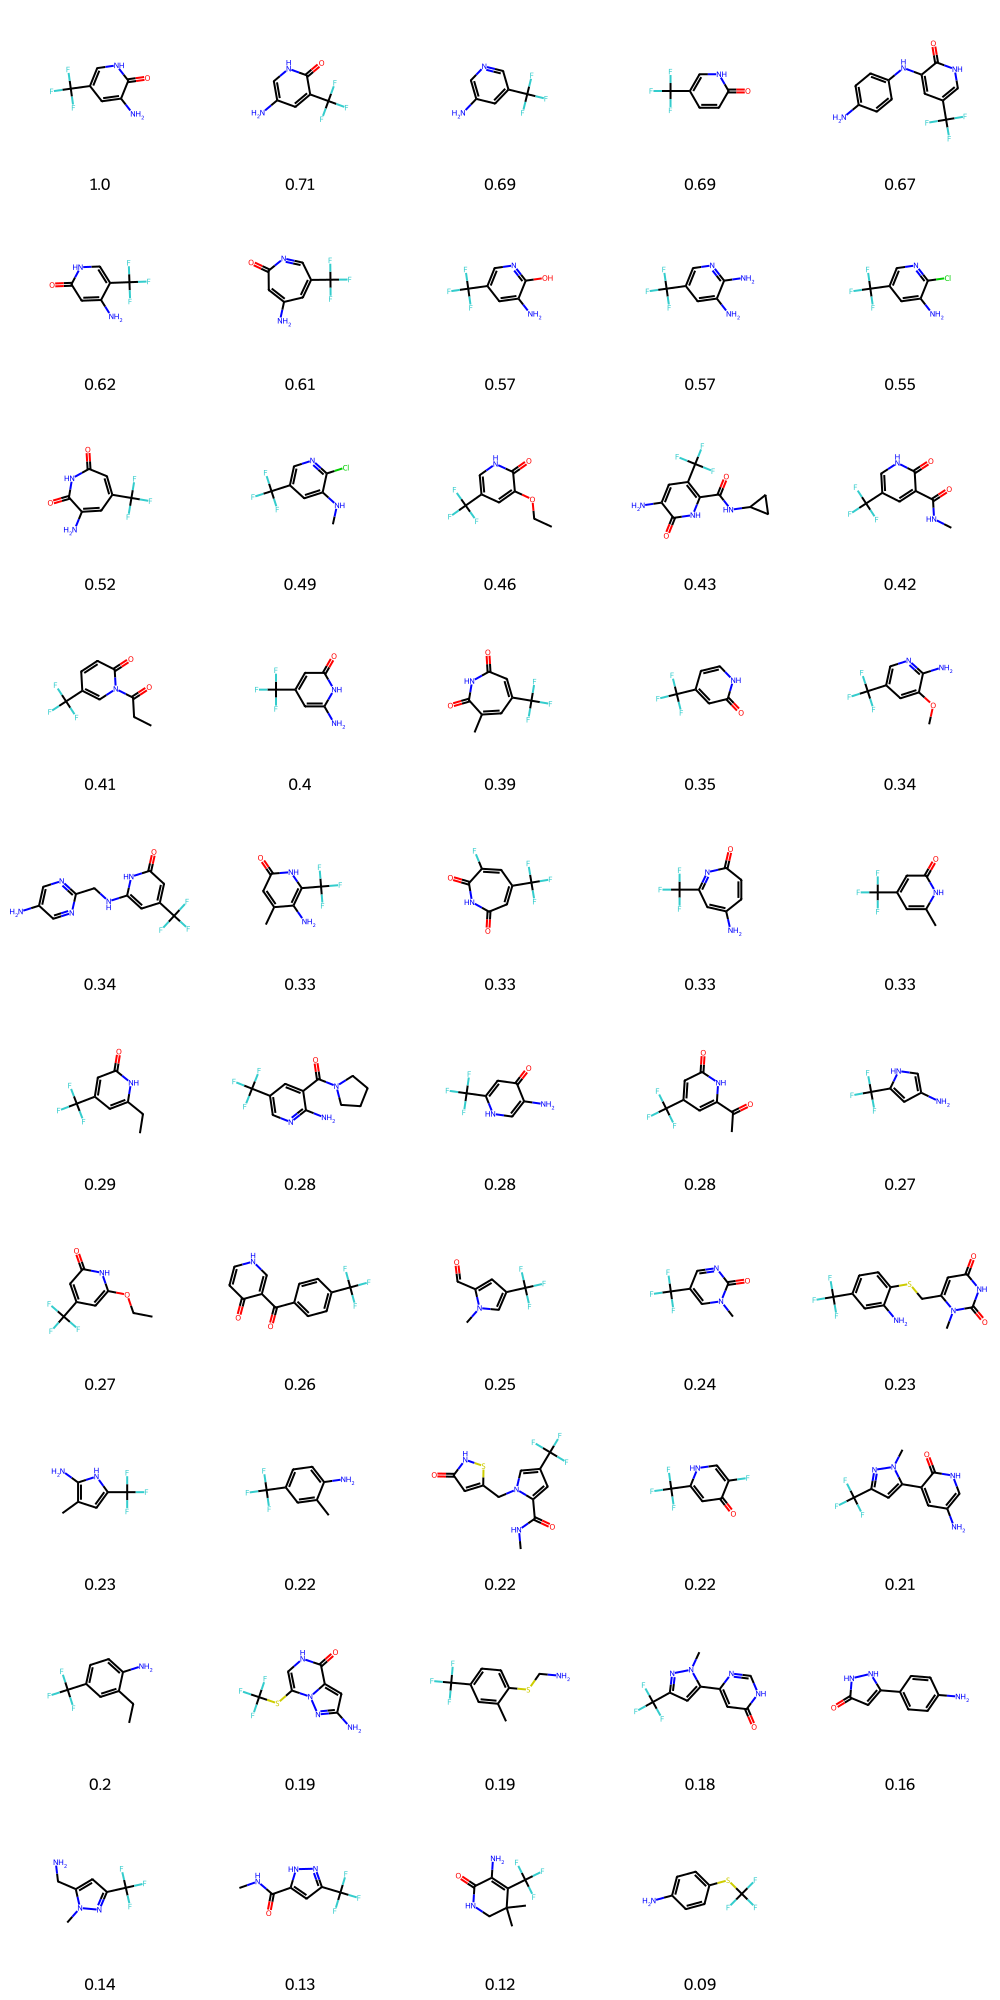

In [19]:
unique_valid_smiles_0p5_1 = gen_mol(smiles_str, coati_version = 1, num_variations = 100, noise_scale = 0.5)

Attempted 100 COATI2 generations with a noise scale of 0.5 and generated 39 unique structures.


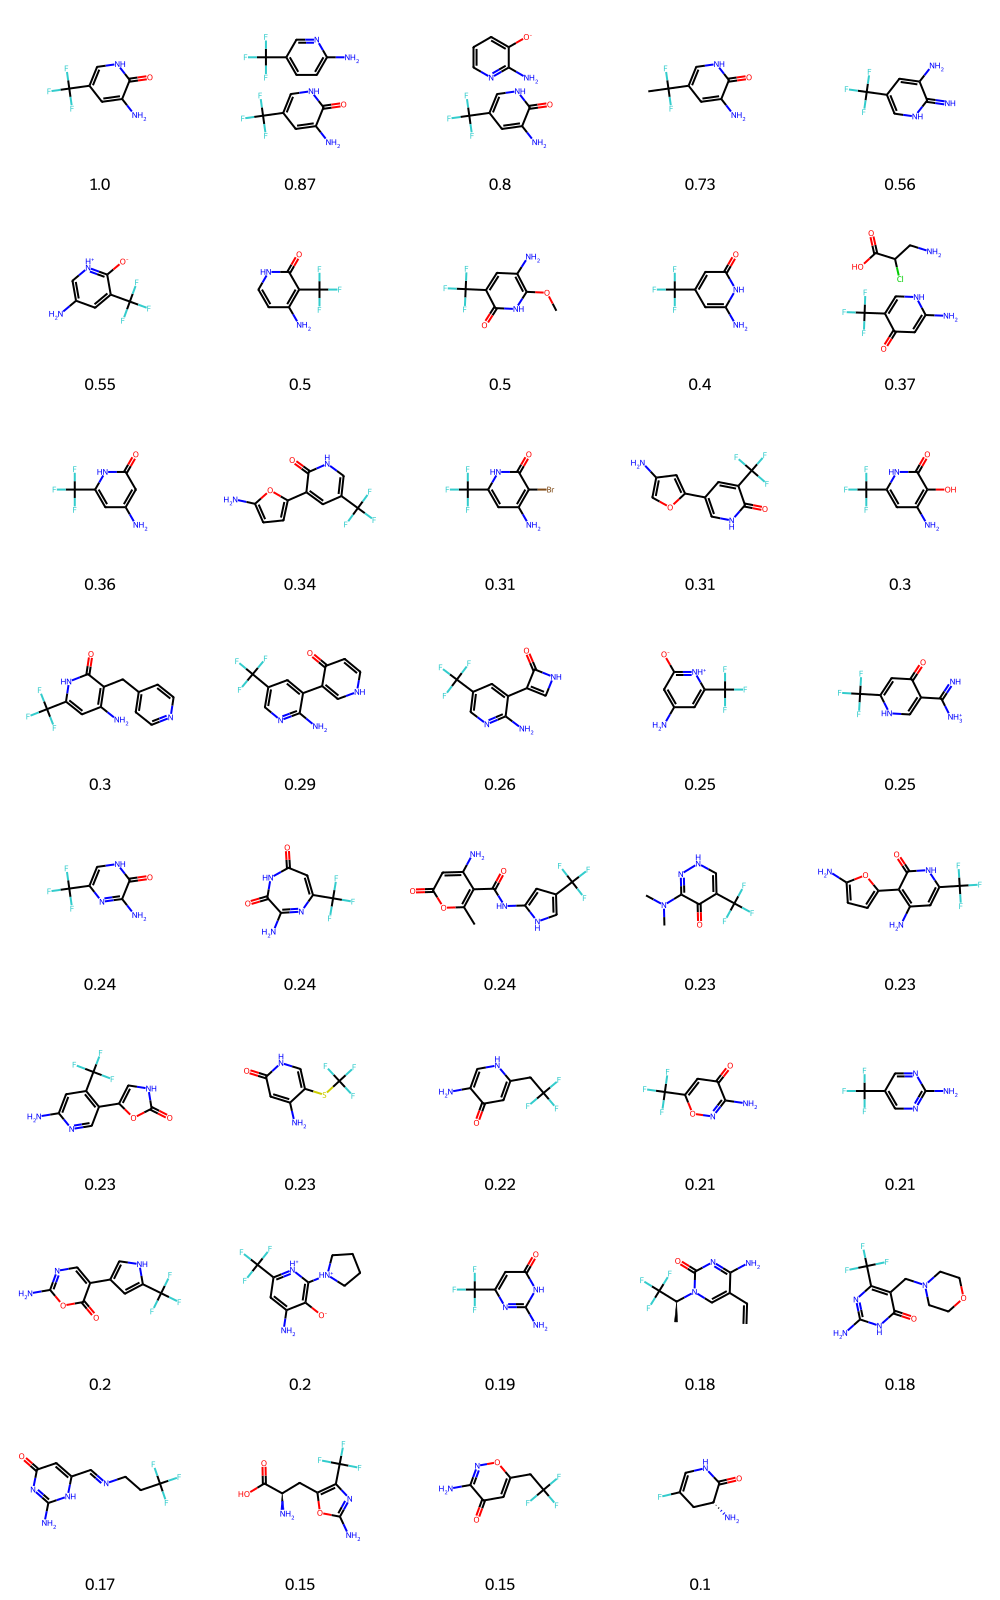

In [20]:
unique_valid_smiles_0p5_2 = gen_mol(smiles_str, coati_version = 2, num_variations = 100, noise_scale = 0.5)